**сиамская сеть, оцениваем схожесть текстов**

Евгений Борисов <esborisov@sevsu.ru>

## Библиотеки

In [1]:
import re
import numpy as np
from numpy import random as rng
import pandas as pd
from tqdm import tqdm
# import gzip

In [2]:
pd.options.display.max_colwidth = 200  
tqdm.pandas()

def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [3]:
# каталог товаров
data = pd.read_excel('../data/okpd2.xlsx')
ppr(data)
data.sample(3)

записей: 19 464


,Код,Наименование,Комментарий
15737,32.50.22.130,Зубы искусственные,NaN
12944,25.30.22.125,Комплектующие (запасные части) активных зон ядерных реакторов и элементов активных зон ядерных реакторов,NaN
8968,11.04.10.120,"Вина прочие ароматизированные, в том числе из свежего винограда",NaN


In [4]:
# нумеруем позиции каталога
data['id'] = range(len(data))
# будем использовать второй уровень каталога (две первые цифры)
data['group'] = data['Код'].str[:5]

In [5]:
# длина описаний в символах
data['Наименование'].str.len().describe([.95]).astype(int)

count    19464
mean        58
std         39
min          3
50%         50
95%        130
max        540
Name: Наименование, dtype: int64

In [6]:
# выкидываем короткие описания и дубликаты
data = data[ (data['group'].str.len()==5) & data['Наименование'].str.len().between(30,100) ]\
  .drop_duplicates(['Наименование'])[['id','group','Наименование']]\
  .reset_index(drop=True)

ppr(data)
data.sample(3)

записей: 9 632


,id,group,Наименование
2313,5014,46.11,Услуги по оптовой торговле живыми животными за вознаграждение или на договорной основе
770,1659,16.21,Листы для облицовки; шпон для фанеры; древесина прессованная
3700,7774,10.11,Говядина и телятина замороженные для детского питания


In [7]:
# формируем списки описаний по группам
groups =  data[['id','group']].groupby('group')['id'].apply(list).reset_index()
ppr(groups)

записей: 596


In [8]:
# количество описаний в группах
groups['id'].str.len().describe([.95]).astype(int)

count    596
mean      16
std       24
min        1
50%        7
95%       62
max      185
Name: id, dtype: int64

In [9]:
# выкидываем группы с малым количеством описаний, обрезаем большие списки
n_samples = 10

ppr(groups)
groups = groups[ groups['id'].str.len()> n_samples ].reset_index(drop=True)
ppr(groups)
groups['id'] = groups['id'].apply(rng.permutation).str[:n_samples]

записей: 596
записей: 227


In [10]:
# похожие примеры
groups['id_eq'] = groups['id'].apply(rng.permutation)

In [11]:
groups

,group,id,id_eq
0,01.11,"[2854, 6119, 6069, 1364, 6156, 6164, 6071, 6073, 18539, 18538]","[6073, 6069, 6156, 1364, 2854, 6071, 6119, 6164, 18539, 18538]"
1,01.13,"[2866, 6239, 2874, 6220, 1379, 6230, 1371, 6226, 1373, 1376]","[1373, 6226, 1379, 1376, 1371, 2866, 2874, 6239, 6220, 6230]"
2,01.15,"[18177, 18165, 6248, 18166, 18178, 18171, 18168, 6245, 18169, 6246]","[18178, 6248, 6246, 18168, 18169, 18166, 18177, 18165, 18171, 6245]"
3,01.16,"[6258, 6264, 6271, 6270, 6253, 6249, 747, 6259, 6272, 2887]","[6272, 747, 6258, 6264, 6253, 2887, 6259, 6270, 6249, 6271]"
4,01.19,"[6285, 6295, 6288, 6298, 6273, 6284, 1384, 2891, 6283, 2894]","[6298, 6283, 1384, 2894, 6285, 6288, 2891, 6273, 6295, 6284]"
...,...,...,...
222,95.29,"[19303, 19288, 19297, 6018, 19317, 19255, 19260, 19307, 19284, 19290]","[19284, 19307, 19260, 19303, 19317, 6018, 19290, 19288, 19255, 19297]"
223,96.01,"[19328, 19358, 19408, 19364, 19373, 19375, 19362, 19397, 19323, 19382]","[19382, 19358, 19328, 19364, 19362, 19373, 19323, 19397, 19408, 19375]"
224,96.02,"[1353, 2818, 6025, 19415, 6027, 19414, 19410, 19411, 2817, 19412]","[19414, 6025, 2818, 19410, 19411, 1353, 2817, 6027, 19415, 19412]"
225,96.03,"[19437, 19442, 19435, 19434, 19443, 6030, 19430, 19433, 19429, 19431]","[19434, 19435, 19442, 19430, 19431, 6030, 19437, 19429, 19443, 19433]"


In [12]:
# непохожие примеры

# пары из разных групп
groups_ = groups[['group']].reset_index(drop=True)
groups_['group_neq'] = rng.permutation(groups['group'])
groups_ = groups_.query('group!=group_neq')

groups_ = groups_.merge( groups[['group','id']]\
                          .rename(columns={'group':'group_neq','id':'id_neq'}), 
                        on=['group_neq'])

groups_['id_neq'] = groups_['id_neq'].apply(rng.permutation)

# groups[['group','id']].rename(columns={'group':'group_neq','id':'id_neq'})

groups_

,group,group_neq,id_neq
0,01.11,26.60,"[13661, 13650, 13632, 13640, 13648, 13637, 13651, 4246, 13642, 4247]"
1,01.13,29.20,"[993, 14907, 14908, 14892, 14900, 4612, 14897, 2149, 2150, 14906]"
2,01.15,23.13,"[12092, 12067, 12088, 12086, 3870, 12078, 12075, 12089, 3868, 12085]"
3,01.16,86.90,"[5936, 5932, 17699, 17700, 5929, 17697, 5935, 5937, 5934, 17696]"
4,01.19,10.89,"[817, 8874, 18402, 8886, 18413, 8868, 1557, 8875, 8871, 18147]"
...,...,...,...
222,95.29,56.10,"[16924, 5395, 16909, 5396, 16919, 16922, 16921, 16929, 16916, 16925]"
223,96.01,10.13,"[7898, 18225, 18276, 18315, 7873, 18233, 18244, 18271, 18215, 18246]"
224,96.02,95.22,"[19136, 19167, 19169, 19176, 19128, 19161, 19173, 19157, 19174, 19156]"
225,96.03,20.13,"[3649, 10965, 10938, 11023, 18554, 10970, 10943, 10847, 10910, 10895]"


In [13]:
# группа, описания, похожие описания, непохожие описания
groups = groups.merge( groups_[['group','id_neq']], on=['group'] )
groups

,group,id,id_eq,id_neq
0,01.11,"[2854, 6119, 6069, 1364, 6156, 6164, 6071, 6073, 18539, 18538]","[6073, 6069, 6156, 1364, 2854, 6071, 6119, 6164, 18539, 18538]","[13661, 13650, 13632, 13640, 13648, 13637, 13651, 4246, 13642, 4247]"
1,01.13,"[2866, 6239, 2874, 6220, 1379, 6230, 1371, 6226, 1373, 1376]","[1373, 6226, 1379, 1376, 1371, 2866, 2874, 6239, 6220, 6230]","[993, 14907, 14908, 14892, 14900, 4612, 14897, 2149, 2150, 14906]"
2,01.15,"[18177, 18165, 6248, 18166, 18178, 18171, 18168, 6245, 18169, 6246]","[18178, 6248, 6246, 18168, 18169, 18166, 18177, 18165, 18171, 6245]","[12092, 12067, 12088, 12086, 3870, 12078, 12075, 12089, 3868, 12085]"
3,01.16,"[6258, 6264, 6271, 6270, 6253, 6249, 747, 6259, 6272, 2887]","[6272, 747, 6258, 6264, 6253, 2887, 6259, 6270, 6249, 6271]","[5936, 5932, 17699, 17700, 5929, 17697, 5935, 5937, 5934, 17696]"
4,01.19,"[6285, 6295, 6288, 6298, 6273, 6284, 1384, 2891, 6283, 2894]","[6298, 6283, 1384, 2894, 6285, 6288, 2891, 6273, 6295, 6284]","[817, 8874, 18402, 8886, 18413, 8868, 1557, 8875, 8871, 18147]"
...,...,...,...,...
222,95.29,"[19303, 19288, 19297, 6018, 19317, 19255, 19260, 19307, 19284, 19290]","[19284, 19307, 19260, 19303, 19317, 6018, 19290, 19288, 19255, 19297]","[16924, 5395, 16909, 5396, 16919, 16922, 16921, 16929, 16916, 16925]"
223,96.01,"[19328, 19358, 19408, 19364, 19373, 19375, 19362, 19397, 19323, 19382]","[19382, 19358, 19328, 19364, 19362, 19373, 19323, 19397, 19408, 19375]","[7898, 18225, 18276, 18315, 7873, 18233, 18244, 18271, 18215, 18246]"
224,96.02,"[1353, 2818, 6025, 19415, 6027, 19414, 19410, 19411, 2817, 19412]","[19414, 6025, 2818, 19410, 19411, 1353, 2817, 6027, 19415, 19412]","[19136, 19167, 19169, 19176, 19128, 19161, 19173, 19157, 19174, 19156]"
225,96.03,"[19437, 19442, 19435, 19434, 19443, 6030, 19430, 19433, 19429, 19431]","[19434, 19435, 19442, 19430, 19431, 6030, 19437, 19429, 19443, 19433]","[3649, 10965, 10938, 11023, 18554, 10970, 10943, 10847, 10910, 10895]"


In [14]:
# разворачиваем в список пар
groups = pd.DataFrame({'id':groups['id'].explode(), 
              'id_eq':groups['id_eq'].explode(),
              'id_neq':groups['id_neq'].explode()})
ppr(groups)
groups.sample(3)

записей: 2 270


,id,id_eq,id_neq
101,4037,1901,9622
220,1349,1349,14363
186,16746,16751,9602


In [15]:
# формируем датасет
pair = groups[['id','id_eq']].rename(columns={'id':'id_L','id_eq':'id_R'})
pair['target'] = 1
pair = pd.concat([ pair, groups[['id','id_neq']]\
           .rename(columns={'id':'id_L','id_neq':'id_R'}) ])\
           .fillna(0).astype(int)

pair.sample(3)

,id_L,id_R,target
13,7165,1443,1
155,2184,2183,1
58,1625,12134,0


In [16]:
%xdel groups
%xdel groups_

## очистка данных

In [17]:
# data['ttext_clean'] = data['ttext']\
#     .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
#     .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
#     .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
#     .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

In [18]:
# data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [19]:
data['ttext_clean'] = data['Наименование'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 9632/9632 [00:00<00:00, 114958.22it/s]


In [20]:
data.sample(3)

,id,group,Наименование,ttext_clean
7593,15285,31.09,"Стеллажи, стойки, вешалки металлические","[стеллажи, стойки, вешалки, металлические]"
4150,8503,10.52,Мороженое кисломолочное с наполнителями и добавками в глазури,"[мороженое, кисломолочное, с, наполнителями, и, добавками, в, глазури]"
6440,12800,24.45,"Германий и изделия из него, порошки","[германий, и, изделия, из, него, порошки]"


In [21]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 9 632
записей: 9 632


In [22]:
data.sample(3)

,id,group,Наименование,ttext_clean
375,1034,36.00,Вода природная; услуги по очистке воды и водоснабжению,"[вода, природная, услуги, по, очистке, воды, и, водоснабжению]"
5314,10394,16.24,Комплекты бочковые и бочки заливные,"[комплекты, бочковые, и, бочки, заливные]"
1946,4274,27.11,"Электродвигатели переменного тока, многофазные, выходной мощностью более 75 кВт","[электродвигатели, переменного, тока, многофазные, выходной, мощностью, более, digit, квт]"


In [23]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 9 976


## кодируем слова

In [24]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 9632/9632 [00:00<00:00, 569015.57it/s]


In [25]:
data[['ttext_clean','code']].sample(3)

,ttext_clean,code
7605,"[гарнитуры, и, наборы, комплектной, мебели, деревянные, для, столовой, и, гостиной]","[1305, 2416, 4436, 3143, 3997, 1738, 1866, 8136, 2416, 1504]"
8627,"[жмых, и, остатки, пищевые, твердые, прочие, полученные, при, экстракции, подсолнечного, масла]","[2146, 2416, 5291, 5787, 8383, 6707, 6218, 6420, 9760, 6023, 3931]"
8077,"[сооружения, для, движения, водного, транспорта, по, рекам, и, каналам]","[7845, 1866, 1650, 963, 8663, 5911, 7117, 2416, 2744]"


In [26]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    9632
mean        7
std         2
min         2
25%         5
50%         7
75%         9
max        16
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

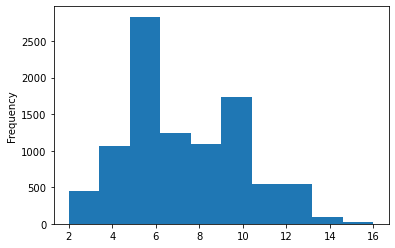

In [27]:
data['code'].str.len().plot.hist()

In [28]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

16

In [29]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 9632/9632 [00:00<00:00, 132312.60it/s]


In [30]:
data['code'].str.len().describe().astype(int)

count    9632
mean       16
std         0
min        16
25%        16
50%        16
75%        16
max        16
Name: code, dtype: int64

In [31]:
# data

## строим датасет

In [32]:
pair

,id_L,id_R,target
0,2854,6073,1
0,6119,6069,1
0,6069,6156,1
0,1364,1364,1
0,6156,2854,1
...,...,...,...
226,19449,17163,0
226,19460,17162,0
226,1356,1214,0
226,19452,2626,0


In [33]:
dataset = pair\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )
ppr(dataset)
dataset.sample(3)

записей: 4 540


,id_L,id_R,target,code_L,code_R
644,7321,7327,1,"[8835, 3054, 3920, 3515, 3051, 7673, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8835, 3920, 3517, 3051, 7673, 4794, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1624,199,158,1,"[7951, 5375, 3695, 6576, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3696, 2461, 3449, 7456, 4, 6707, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3851,16164,16174,1,"[8747, 3847, 4469, 2416, 5965, 1866, 5604, 4768, 2416, 1232, 0, 0, 0, 0, 0, 0]","[6818, 5911, 654, 975, 7629, 2515, 5370, 3083, 8696, 7935, 2880, 0, 0, 0, 0, 0]"


In [34]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((4540, 16), (4540, 16), (4540, 1))

In [35]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [36]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((4540, 16), (4540, 16), (4540, 1), 9976)

In [37]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [38]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

16

In [39]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [40]:
# отделяем тестовый набор
x_train, x_test, y_train, y_test = train_test_split( np.hstack([x_left,x_right]), target, test_size=.5)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2270, 32), (2270, 1), (2270, 32), (2270, 1))

In [41]:
x_left_train, x_right_train = x_train[:,:seq_len],x_train[:,seq_len:]
y_train = y_train.flatten()
x_left_train.shape, x_right_train.shape, y_train.shape

((2270, 16), (2270, 16), (2270,))

In [42]:
x_left_test, x_right_test = x_test[:,:seq_len],x_test[:,seq_len:]
y_test = y_test.flatten()
x_left_test.shape, x_right_test.shape, y_test.shape

((2270, 16), (2270, 16), (2270,))

In [43]:
# %xdel x_left
# %xdel x_right
# %xdel target

In [44]:
# gc.collect()

In [45]:
# y_train.sum()/len(y_train), y_test.sum()/len(y_test)

## модель

In [46]:
embed_len = 128
embed_input_dim, embed_len, seq_len

(9976, 128, 16)

In [47]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.4.0', '2.4.0')

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.losses import contrastive_loss

In [49]:
from tensorflow import cast

def contrastive_loss(y, preds, margin=1):
    y = cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean(y * K.square(preds) + (1 - y) * squaredMargin)

$$
y \cdot p^2 + (1 - y) \cdot ( 1-p ) ^2
$$

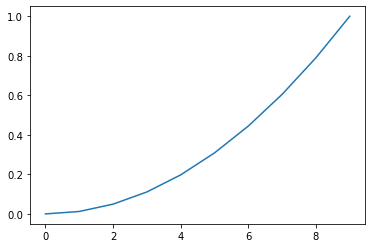

In [50]:
from matplotlib import pyplot as plt

y = np.ones(10)
p = np.linspace(0,1,10)

# y = np.zeros(10)
# p = np.linspace(1,0,10)

plt.plot( y*(p**2) + (1-y)*((1-p)**2) )

In [51]:
embed_input_dim,seq_len,embed_len

(9976, 16, 128)

In [52]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )
lstm = LSTM(embed_len,activation='relu') 

In [53]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

In [54]:
# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

In [55]:
# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

In [56]:
# классификатор
predictions = Dense(1, activation='relu')(merged)

In [57]:
# создаём модель
model = Model([input_l,input_r], predictions )

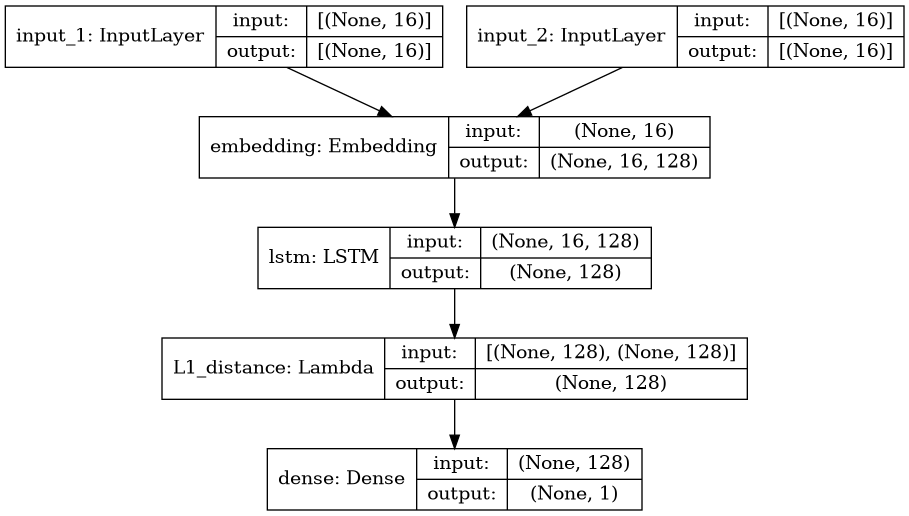

In [58]:
plot_model(model,
           #to_file=pjoin(FOLDER_RESULT,'model-embed-lstm.png'), 
           show_layer_names=True, show_shapes=True )
# model.summary()

In [59]:
learning_rate = 9e-3
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [60]:
%%time

n_epochs = 25

history = model.fit( [x_left_train, x_right_train], y_train,
           epochs = n_epochs,
           batch_size = 4096,
           # validation_split=.2,
         )

Epoch 1/25
1/1 [==============================] - 3s 3s/step - loss: 0.5021 - acc: 0.5022
Epoch 2/25
1/1 [==============================] - 0s 83ms/step - loss: 0.4516 - acc: 0.5022
Epoch 3/25
1/1 [==============================] - 0s 79ms/step - loss: 0.3572 - acc: 0.5022
Epoch 4/25
1/1 [==============================] - 0s 79ms/step - loss: 0.4012 - acc: 0.4013
Epoch 5/25
1/1 [==============================] - 0s 79ms/step - loss: 0.2274 - acc: 0.4454
Epoch 6/25
1/1 [==============================] - 0s 78ms/step - loss: 0.2313 - acc: 0.4744
Epoch 7/25
1/1 [==============================] - 0s 76ms/step - loss: 0.2047 - acc: 0.3802
Epoch 8/25
1/1 [==============================] - 0s 77ms/step - loss: 0.1604 - acc: 0.2661
Epoch 9/25
1/1 [==============================] - 0s 77ms/step - loss: 0.1234 - acc: 0.1749
Epoch 10/25
1/1 [==============================] - 0s 78ms/step - loss: 0.1134 - acc: 0.1374
Epoch 11/25
1/1 [==============================] - 0s 78ms/step - loss: 0.1144 - 

----

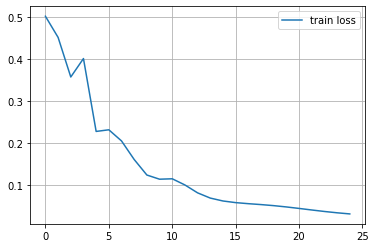

In [61]:
plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

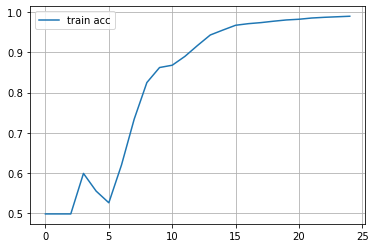

In [62]:
plt.plot( 1. - np.array(history.history['acc']), label='train acc')
# plt.plot( np.array(history.history['val_acc']), label='val acc')
plt.legend()
plt.grid()

In [63]:
# gc.collect()

## тест

In [64]:
# dataset.sample(2)

In [65]:
dataset['dist'] = model.predict([x_left,x_right,])

In [66]:
data_dist = dataset[['id_L','id_R','target','dist']]\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_R','Наименование':'ttext_R'}),on='id_R')\
    .merge(data[['id','Наименование']].rename(columns={'id':'id_L','Наименование':'ttext_L'}),on='id_L')\
    [['ttext_L','ttext_R','dist']]
# data_dist.sample(3)

In [67]:
data_dist[['dist']].describe().T

,count,mean,std,min,25%,50%,75%,max
dist,4540.0,0.700882,0.50953,0.056379,0.226269,0.63806,1.083852,2.442996


In [68]:
# похожие тексты
data_dist[ (data_dist['dist']<0.5) & (data_dist['ttext_L']!=data_dist['ttext_R']) ].sample(5)

,ttext_L,ttext_R,dist
1627,"Услуги в области картографии, кроме услуг в области кадастровой деятельности",Услуги по инженерно-техническому проектированию зданий,0.204517
2646,"Куртки мужские или для мальчиков из текстильных материалов, кроме трикотажных или вязаных","Пальто, полупальто мужские или для мальчиков трикотажные или вязаные",0.220851
1176,"Услуги вспомогательные, связанные с космическим транспортом",Услуги по управлению воздушным движением,0.103882
1265,Подшипники качения роликовые с витыми роликами радиальные,Муфты механические управляемые,0.153323
3883,Услуги по ведению (восстановлению) бухгалтерского учета,Услуги по налоговому консультированию и подготовка налоговой документации для юридических лиц,0.261267


In [69]:
# НЕпохожие тексты
data_dist[ (data_dist['dist']>0.5) & (data_dist['ttext_L']!=data_dist['ttext_R']) ].sample(5)

,ttext_L,ttext_R,dist
741,"Продукты пищевые прочие, содержащие какао (кроме подслащенного какао-порошка), в неупакованном виде",Работы по установке строительных лесов и подмостей,1.084550
2333,"Краски на основе сложных полиэфиров, акриловых или виниловых полимеров в неводной среде","Резервуары, цистерны, баки и аналогичные емкости пластмассовые вместимостью свыше 300 л",1.140303
447,"Резервуары, цистерны и аналогичные емкости из металлов прочие",Полотно железнодорожное для подземных или надземных городских систем скоростного транспорта,0.940312
1595,"Жмых и прочие остатки пищевые твердые, полученные при экстракции сурепного масла",Табло световые и аналогичные устройства,0.675673
4093,"Услуги, оказываемые средним медицинским персоналом центров реабилитации",Услуги по страхованию автотранспортных средств,0.956607
